# Plan 0 diagnosis notebook (K selection + factor sanity checks)

This notebook is for **Plan 0 → diagnosis** in `sc_classification/scripts/comprehensive_run/`.

It is designed to work with experiments produced by:

- `sc_classification/scripts/comprehensive_run/run_gene_filter_dr_grid.py plan0`

Key ideas from the plan:

- Use a single reference preprocess (e.g. MRD + CITE + HVG=10k) to pick **K per DR method**.
- Use **diagnostics + stability** (multi-seed loadings similarity) to avoid choosing K that yields unstable/noisy factors.
- For cNMF, use its native outputs for replicate storage and run `combine_nmf()` + `consensus()`.

Links:

- Plans index: `../plans/INDEX.md`
- Active plan: `../plans/active_plan0_plan1.md`


In [1]:
from __future__ import annotations

from pathlib import Path
import json

import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (8, 5)


In [2]:
# ---- set your experiment here ----
EXP_DIR = Path(
    "/home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886"
)

PREPROCESSED = EXP_DIR / "preprocessing" / "adata_processed.h5ad"
K_SELECTION_SUMMARY = EXP_DIR / "analysis" / "plan0" / "k_selection_summary.csv"

print("EXP_DIR:", EXP_DIR)
print("preprocessed exists:", PREPROCESSED.exists(), PREPROCESSED)
print("k_selection_summary exists:", K_SELECTION_SUMMARY.exists(), K_SELECTION_SUMMARY)


EXP_DIR: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886
preprocessed exists: True /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/preprocessing/adata_processed.h5ad
k_selection_summary exists: True /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/k_selection_summary.csv


## Optional: rehydrate Plan 0 DR caches into the preprocessed AnnData

This uses the helper script:

- `sc_classification/scripts/comprehensive_run/attach_plan0_dr_cache_to_preprocessed_adata.py`

Notes:

- This attaches **PCA/FA/FactoSig** results (fit on the standardized Plan 0 AnnData).
- If your Plan 0 crashed before PCA ran (e.g. crashed at cNMF), just set `ATTACH_METHODS = "fa,factosig"`.
- By default it writes a new file with **K and seed in the filename**:
  - `adata_processed_with_plan0_dr_k<K>_seed<SEED>.h5ad`


In [5]:
import subprocess

# Pick one K/seed you want to inspect in AnnData form
ATTACH_K = 60
ATTACH_SEED = 1

# If plan0 crashed before PCA ran, use: "fa,factosig"
ATTACH_METHODS = "fa,factosig"

ATTACHED = EXP_DIR / "preprocessing" / f"adata_processed_with_plan0_dr_k{ATTACH_K}_seed{ATTACH_SEED}.h5ad"

cmd = [
    "python",
    "/home/minhang/mds_project/sc_classification/scripts/comprehensive_run/attach_plan0_dr_cache_to_preprocessed_adata.py",
    "--experiment-dir",
    str(EXP_DIR),
    "--methods",
    ATTACH_METHODS,
    "--k",
    str(ATTACH_K),
    "--seed",
    str(ATTACH_SEED),
    "--attach-consensus",
]

print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("attached exists:", ATTACHED.exists(), ATTACHED)


Running: python /home/minhang/mds_project/sc_classification/scripts/comprehensive_run/attach_plan0_dr_cache_to_preprocessed_adata.py --experiment-dir /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886 --methods fa,factosig --k 60 --seed 1 --attach-consensus
attached exists: True /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/preprocessing/adata_processed_with_plan0_dr_k60_seed1.h5ad


In [6]:
# Load attached AnnData (or fall back to the preprocessed one)
adata_path = ATTACHED if ATTACHED.exists() else PREPROCESSED
adata = sc.read_h5ad(adata_path)

print("Loaded:", adata_path)
print("shape:", adata.shape)
print("obs columns (subset):", list(adata.obs.columns)[:25])
print("obsm keys:", list(adata.obsm.keys()))
print("varm keys:", list(adata.varm.keys())[:10], "... total", len(adata.varm.keys()))
print("uns keys (subset):", list(adata.uns.keys())[:25])


Loaded: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/preprocessing/adata_processed_with_plan0_dr_k60_seed1.h5ad
shape: (60118, 10000)
obs columns (subset): ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior']
obsm keys: ['ADT', 'X_fa', 'X_factosig', '_scvi_extra_categorical_covs']
varm keys: ['FACTOSIG_loadings', 'FA_loadings'] ... total 2
uns keys (subset): ['_scvi_manager_uuid', '_scvi_uuid', 'fa', 'factosig', 'hvg', 'plan0_cache_attach']


## K selection table (Plan 0 summary)

`k_selection_summary.csv` is meant to support the “2-axis” K selection view:

- **stability** proxy: median best-match loading correlation across replicate pairs
- **variance_proxy**: quick variance / score-variance proxy (method-dependent)
- **consensus_silhouette**: FA/FactoSig component clustering diagnostic (if computed)


In [7]:
import subprocess

if not K_SELECTION_SUMMARY.exists():
    print("Missing:", K_SELECTION_SUMMARY)
    print("Rebuilding from cached Plan 0 outputs...")
    subprocess.run(
        [
            "python",
            "sc_classification/scripts/comprehensive_run/build_plan0_k_selection_summary.py",
            "--experiment-dir",
            str(EXP_DIR),
            "--seed",
            "1",
        ],
        check=True,
    )

if K_SELECTION_SUMMARY.exists():
    ksum = pd.read_csv(K_SELECTION_SUMMARY)
    display(ksum)
else:
    print("Still missing (something is wrong with cached outputs):", K_SELECTION_SUMMARY)
    ksum = None


,method,k,n_seeds,stability_best_a_median,stability_best_a_mean,stability_frac_lt_0p3,consensus_silhouette,variance_proxy
0,fa,20,1,NaN,NaN,NaN,NaN,19.535331
1,fa,40,1,NaN,NaN,NaN,NaN,38.002381
2,fa,60,1,NaN,NaN,NaN,NaN,55.438378
3,factosig,20,1,NaN,NaN,NaN,NaN,21.282615
4,factosig,40,1,NaN,NaN,NaN,NaN,38.499794
5,factosig,60,1,NaN,NaN,NaN,NaN,55.467121


In [ ]:
if ksum is not None and not ksum.empty:
    # stability vs variance proxy
    g = sns.FacetGrid(ksum, col="method", col_wrap=3, sharex=False, sharey=False, height=4)
    g.map_dataframe(sns.scatterplot, x="variance_proxy", y="stability_best_a_median", hue="k", palette="viridis")
    g.add_legend()
    g.set_axis_labels("variance proxy", "loading stability (median best-match corr)")
    plt.show()


## Factor sanity checks (for one chosen K)

Below are quick checks that mirror what you’ve done in prior notebooks:

- **Does the embedding separate `CN.label`?** (basic sanity)
- **Are factors dominated by patient/technical artifacts?** (confounding)
- **Top genes per factor** (interpretability)


/home/minhang/miniconda3/envs/gene_filter_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available color keys: ['CN.label', 'patient', 'timepoint_type']


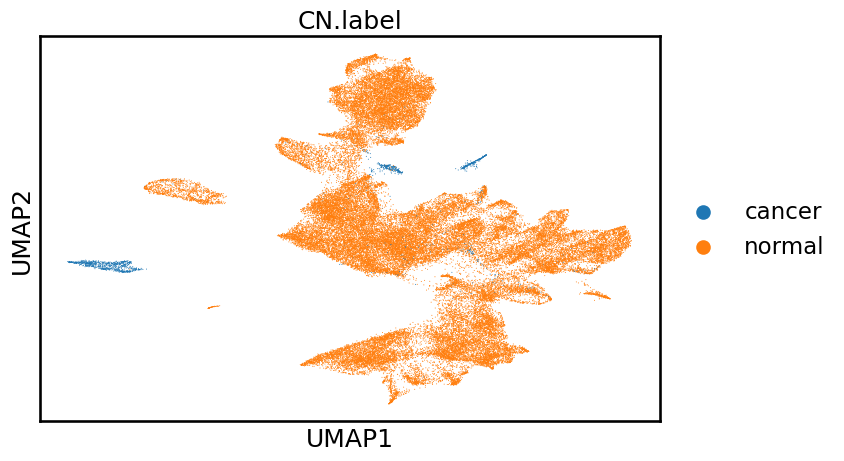

In [10]:
# Choose which embedding to inspect here
EMB_KEY = "X_fa"  # one of: X_pca, X_fa, X_factosig

assert EMB_KEY in adata.obsm, f"Missing {EMB_KEY} in adata.obsm (did you attach caches?)"

# Make a quick UMAP on the chosen embedding
sc.pp.neighbors(adata, use_rep=EMB_KEY, n_neighbors=15)
sc.tl.umap(adata, min_dist=0.3)

color_keys = [k for k in ["CN.label", "patient", "timepoint_type", "tech", "leiden"] if k in adata.obs.columns]
print("Available color keys:", color_keys)

sc.pl.umap(adata, color=["CN.label"] if "CN.label" in adata.obs.columns else None)


In [11]:
# Top genes per factor (loading inspection)

def top_genes_from_varm(loadings_key: str, factor_idx: int, n: int = 30) -> pd.DataFrame:
    L = np.asarray(adata.varm[loadings_key])  # (genes, k)
    v = L[:, factor_idx]
    order = np.argsort(np.abs(v))[::-1][:n]
    out = pd.DataFrame(
        {
            "gene": adata.var_names[order].to_list(),
            "loading": v[order],
            "abs_loading": np.abs(v[order]),
        }
    )
    return out

# Map embedding -> loading key
loading_key_by_emb = {
    "X_pca": "PCA_loadings",
    "X_fa": "FA_loadings",
    "X_factosig": "FACTOSIG_loadings",
}
LOAD_KEY = loading_key_by_emb[EMB_KEY]

print("Using loadings:", LOAD_KEY)

for fi in range(5):
    print("\n--- factor", fi, "---")
    display(top_genes_from_varm(LOAD_KEY, fi, n=25))


Using loadings: FA_loadings

--- factor 0 ---


,gene,loading,abs_loading
0,YBX1,0.955899,0.955899
1,NPM1,0.938639,0.938639
2,RPL14,0.934754,0.934754
3,RPL4,0.932725,0.932725
4,RPL23,0.925264,0.925264
5,RPLP0,0.923371,0.923371
6,RPS17,0.922063,0.922063
7,SERBP1,0.917997,0.917997
8,RPL8,0.917544,0.917544
9,HSPD1,0.915093,0.915093



--- factor 1 ---


,gene,loading,abs_loading
0,PRKCE,0.693715,0.693715
1,DLEU2,0.692194,0.692194
2,AUTS2,0.687043,0.687043
3,TTC7A,0.668428,0.668428
4,ZMIZ1,0.652005,0.652005
5,PAG1,0.647986,0.647986
6,MEF2A,0.638698,0.638698
7,SCMH1,0.629913,0.629913
8,RCSD1,0.629146,0.629146
9,DOCK10,0.628255,0.628255



--- factor 2 ---


,gene,loading,abs_loading
0,GSTP1,-0.614094,0.614094
1,CYBA,-0.601629,0.601629
2,AIF1,-0.555327,0.555327
3,VIM,-0.495198,0.495198
4,HLA-DRB1,-0.490634,0.490634
5,HLA-DPA1,-0.484310,0.484310
6,CORO1A,-0.480055,0.480055
7,ENO1,-0.479743,0.479743
8,RAB32,-0.479257,0.479257
9,ITGB2,-0.460551,0.460551



--- factor 3 ---


,gene,loading,abs_loading
0,ZNF804A,0.542388,0.542388
1,MSRB3,0.524715,0.524715
2,ZNF521,0.515606,0.515606
3,LRMDA,0.513503,0.513503
4,RNF220,0.508737,0.508737
5,NKAIN2,0.504710,0.504710
6,STXBP5,0.495903,0.495903
7,ATP2C1,0.486235,0.486235
8,ANKRD28,0.479300,0.479300
9,ZBTB20,0.472764,0.472764



--- factor 4 ---


,gene,loading,abs_loading
0,RAB11FIP1,0.649442,0.649442
1,SULF2,0.607651,0.607651
2,SAMHD1,0.591669,0.591669
3,SH2B3,0.582663,0.582663
4,CTSZ,0.576873,0.576873
5,UGCG,0.550190,0.550190
6,PLD4,0.533649,0.533649
7,CST3,0.531635,0.531635
8,FCER1G,0.530555,0.530555
9,IRF8,0.523094,0.523094


## Read stability summaries directly from disk (no attach needed)

Plan 0 writes loading-stability summaries here:

- `analysis/plan0/stability/<method>/k_<K>/pairwise_stability_summary.json`

This is useful for comparing K without rehydrating AnnData.


In [12]:
def read_plan0_stability(method: str, k: int) -> dict:
    p = EXP_DIR / "analysis" / "plan0" / "stability" / method / f"k_{int(k)}" / "pairwise_stability_summary.json"
    if not p.exists():
        return {"path": str(p), "exists": False}
    with open(p, "r") as f:
        obj = json.load(f)
    obj["path"] = str(p)
    obj["exists"] = True
    return obj

for method in ["fa", "factosig", "pca"]:
    for k in [20, 40, 60]:
        s = read_plan0_stability(method, k)
        if not s.get("exists"):
            continue
        print(method, k, "median=", s.get("best_a_median_over_pairs"), "frac_lt_0.3=", s.get("best_a_frac_lt_0p3_over_pairs"))


fa 20 median= None frac_lt_0.3= None
fa 40 median= None frac_lt_0.3= None
fa 60 median= None frac_lt_0.3= None
factosig 20 median= None frac_lt_0.3= None
factosig 40 median= None frac_lt_0.3= None
factosig 60 median= None frac_lt_0.3= None


## (Optional) Boilerplate analysis helpers in `src/`

If you move from Plan 0 diagnosis into Plan 1 grid results, the codebase already has analysis utilities:

- `sc_classification/src/sc_classification/utils/experiment_analysis.py`
  - `ExperimentAnalyzer` can load experiments, extract classification metrics, and generate reports.

This notebook intentionally stays lightweight for Plan 0 (no classification yet), but you can reuse those helpers once you run `plan1`.
